Check if saving and everything else has been correctly done after run the script for prestim later none filter on eCortex

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne.datasets import sample
from mne.decoding import cross_val_multiscore, LinearModel, GeneralizingEstimator, Scaler, \
                         Vectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, StratifiedShuffleSplit, \
                                    RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

import argparse

import pickle

# Set args

In [2]:
class arguments:
    def __init__(self, cond_block, cond_decoding, applyBaseline_bool, mtdt_feat, occ_channels):
        self.cond_block = cond_block #'later' #{early,later}
        self.cond_decoding = cond_decoding #'removeevoked' #{none,removeevoked,resampled}
        self.applyBaseline_bool = applyBaseline_bool #'False'
        self.mtdt_feat = mtdt_feat
        self.occ_channels = occ_channels
        
        self.SAVE_EPOCH_ROOT = '../../../data/version5.2/preprocessed/epochs/aft_ICA_rej/'
        self.SAVE_RESULT_ROOT = '../../../results/temp_gen/eCortex/'
        self.cond_filter ='none' # {none,non_symm}
        self.cond_time = 'prestim' #{prestim,poststim}
        self.subj_num = 1
        self.pre_tmin = -0.4
        self.pre_tmax = 0.05
        self.post_tmin = 0.05
        self.post_tmax = 0.45
        self.num_classes = 2
        self.normalization_type = 'normal'# {normal,lstmPaper}
        self.gen_rand_perm = 0
        self.null_max_iter = 10000
        self.loop_null_iter = 5
        self.gen_decoder_scores = 1
        self.random_state = 42 
        self.max_iter = 10000
        self.n_jobs = 1
        self.scoring = 'roc_auc'
        self.n_splits = '_3k'
        self.smooth_lvl = 55
        self.occ_channels = 'True'
        print(self.SAVE_RESULT_ROOT)



In [3]:
"""
Reading and preparing epoch data to create each 4 grous and 2 pattern
"""
import mne
import numpy as np
from scipy.signal import savgol_filter

def read_prep_epochs(args):


    if args.applyBaseline_bool:
        filename_epoch = args.SAVE_EPOCH_ROOT + \
                         'epochs_sec_applyBaseline_subj%s-afterRejICA-epo.fif' \
                          %args.subj_num
    else:
        filename_epoch = args.SAVE_EPOCH_ROOT + \
                         'epochs_sec_subj%s-afterRejICA-epo.fif' \
                         %args.subj_num
    epochs_orig = mne.read_epochs(filename_epoch, proj=True, preload=True,
                                  verbose=None)
    epochs = epochs_orig.copy()
    subset = epochs['pred']['non'].copy()
    subset = subset.pick_types(eeg=True)
    if (args.cond_decoding=='removeevoked'):
        # REMOVE EVOKED RESP.
        subset.subtract_evoked()    # remove evoked response
    elif (args.cond_decoding=='resampled'):
        # RESAMPLE
        subset = subset.resample(args.n_resampling, npad='auto')
    else:
        pass
    ##==========================================================================
    # Select EEG channels of the back
    if args.occ_channels:
        picks_back_brain = ['E56', 'E63', 'E68', 'E73', 'E81', 'E88', 'E94', 'E99', 'E107',
        'E57', 'E64', 'E69', 'E74', 'E82', 'E89', 'E95', 'E100',
        'E50', 'E58', 'E65', 'E70', 'E75', 'E83', 'E90', 'E96', 'E101',
        'E51', 'E59', 'E66', 'E71', 'E76', 'E84', 'E91', 'E97',
        'E52', 'E60', 'E67', 'E72', 'E77', 'E85', 'E92'
        'E53', 'E61', 'E62', 'E78','E86'
        ]
        subset = subset.pick_types(eeg=True, selection=picks_back_brain)
    ##==========================================================================
    if subset['Block==7'].metadata.Ptrn_Type.values.shape[0]>0:
       main_ptrn = subset['Block==7'].metadata.Ptrn_Type.values[0]
    else:
       main_ptrn = subset['Block==8'].metadata.Ptrn_Type.values[0]
    ##==========================================================================
    if args.cond_block=='early': #block 3-6
        subset = subset['Block<7'].copy()
        subset = subset['Block>2'].copy()
    elif args.cond_block=='later':#block 7-10
        subset = subset['Block<11'].copy()
        subset = subset['Block>6'].copy()
    elif args.cond_block=='diff':
        se = subset['Block<7'].copy() # early blocks
        se = se['Block>2'].copy()
        print('earlier blocks shape:\n')
        print(se._data.shape)
        sl= subset['Block<11'].copy() # later blocks
        sl = sl['Block>6'].copy()
        print('later blocks shape:\n')
        print(sl._data.shape)
        subset._data=sl._data-se._data
    elif args.cond_block=='rand':
        subset = subset['Block<3'].copy()
    elif args.cond_block=='b3':
        subset = subset['Block==3'].copy()
    elif args.cond_block=='b10':
        subset = subset['Block==10'].copy()
    elif args.cond_block=='b34':
        subset = subset['Block<5'].copy()
        subset = subset['Block>2'].copy()
    elif args.cond_block=='b910':
        subset = subset['Block<11'].copy()
        subset = subset['Block>8'].copy()
    ##==========================================================================
    subset= subset.crop(tmin=-0.45, tmax=0.45)
    # if (args.cond_time=='prestim'):
    #     subset= subset.crop(tmin=-0.4, tmax=0.05)
    # if (args.cond_time=='poststim'):
    #     subset= subset.crop(tmin=0.05, tmax=0.45)
    # print('Shape of data after crop time is\n :')
    print(subset._data.shape)
    ##==========================================================================
    # Group data based on the previous trial
     # Group data based on the current main loc
    Grp1 = subset['%s==1' %(args.mtdt_feat)].copy()
    Grp2 = subset['%s==2' %(args.mtdt_feat)].copy()
    Grp3 = subset['%s==3' %(args.mtdt_feat)].copy()
    Grp4 = subset['%s==4' %(args.mtdt_feat)].copy()

    # Grp1 = subset['Trgt_Loc_prev==1'].copy()
    # Grp2 = subset['Trgt_Loc_prev==2'].copy()
    # Grp3 = subset['Trgt_Loc_prev==3'].copy()
    # Grp4 = subset['Trgt_Loc_prev==4'].copy()
    if main_ptrn==1:
        Grp1 = Grp1['Trgt_Loc_main!=4'].copy()
        Grp2 = Grp2['Trgt_Loc_main!=1'].copy()
        Grp3 = Grp3['Trgt_Loc_main!=2'].copy()
        Grp4 = Grp4['Trgt_Loc_main!=3'].copy()
    ##==========================================================================
    frequencies = np.arange(3, 13, 2)
    if args.cond_decoding=='non_symm':
        Grp1 = apply_nonSymm_filter(Grp1, frequencies)
        Grp2 = apply_nonSymm_filter(Grp2, frequencies)
        Grp3 = apply_nonSymm_filter(Grp3, frequencies)
        Grp4 = apply_nonSymm_filter(Grp4, frequencies)
    ##==========================================================================
    inds = np.zeros((4,1))
    for iind in range(4):
        inds[iind] = subset['%s==%s' %(args.mtdt_feat, iind+1)]._data.shape[0]

    ind1=int(min(inds))
    ind2=subset['%s==1' %(args.mtdt_feat)]._data.shape[1]
    ind3=subset['%s==1' %(args.mtdt_feat)]._data.shape[2]
    print('minimum ind across four groups: ', ind1)
    ##==========================================================================
    # Equalize the number of each group
    # Grp1._data = Grp1._data[:ind1,:,:]
    # Grp2._data = Grp2._data[:ind1,:,:]
    # Grp3._data = Grp3._data[:ind1,:,:]
    # Grp4._data = Grp4._data[:ind1,:,:]
    ##==========================================================================
    print('the pattern for this subj is :=====================================')
    print(main_ptrn)
    print('          ')
    print('===================================================================')
    ##==========================================================================
    # Normalizing the data for each subject
    if args.normalization_type=='normal':
        Grp1._data = (Grp1._data - np.mean(Grp1._data)) / np.std(Grp1._data)
        Grp2._data = (Grp2._data - np.mean(Grp2._data)) / np.std(Grp2._data)
        Grp3._data = (Grp3._data - np.mean(Grp3._data)) / np.std(Grp3._data)
        Grp4._data = (Grp4._data - np.mean(Grp4._data)) / np.std(Grp4._data)
    elif args.normalization_type=='lstmPaper':
        Grp1._data = (2 * (Grp1._data - np.min(Grp1._data))) \
                        / (np.max(Grp1._data) - np.min(Grp1._data) - 1)
        Grp2._data = (2 * (Grp2._data - np.min(Grp2._data))) \
                        / (np.max(Grp2._data) - np.min(Grp2._data) - 1)
        Grp3._data = (2 * (Grp3._data - np.min(Grp3._data))) \
                        / (np.max(Grp3._data) - np.min(Grp3._data) - 1)
        Grp4._data = (2 * (Grp4._data - np.min(Grp4._data))) \
                        / (np.max(Grp4._data) - np.min(Grp4._data) - 1)
    ##==========================================================================
    Grps_dt = np.zeros((4, ind1, ind2, ind3))
    Grps_dt[0,:,:,:]=Grp1._data[:ind1,:,:]
    Grps_dt[1,:,:,:]=Grp2._data[:ind1,:,:]
    Grps_dt[2,:,:,:]=Grp3._data[:ind1,:,:]
    Grps_dt[3,:,:,:]=Grp4._data[:ind1,:,:]
    Grps_avg = np.mean(Grps_dt, axis=1)
    ##==========================================================================
    # smoothing data
    evk_data = np.mean(Grps_avg, axis=1)
    smooth_evk = np.zeros((5, evk_data.shape[1]))
    smooth_evk[0,:] = savgol_filter(evk_data[0,:], args.smooth_lvl, 3)
    smooth_evk[1,:] = savgol_filter(evk_data[1,:], args.smooth_lvl, 3)
    smooth_evk[2,:] = savgol_filter(evk_data[2,:], args.smooth_lvl, 3)
    smooth_evk[3,:] = savgol_filter(evk_data[3,:], args.smooth_lvl, 3)
    smooth_evk[4,:] = savgol_filter(np.mean(evk_data, 0), args.smooth_lvl, 3)
    ##==========================================================================
    # return Grp1, Grp2, Grp3, Grp4, main_ptrn
    return Grp1, Grp2, Grp3, Grp4, Grps_dt, Grps_avg, smooth_evk, main_ptrn


# Utils functions

### load nested list results using pickle

In [4]:
# problematic_subejcts = [37, 42]
selected_subj_P1 = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15, 16, \
                    42, 43, 44, 45, 47, 48, 51, 52, 53, \
                    55, 56, 57, 58, 59, 60, 61, 62, 63, 64, \
                    66, 67, 68, 69, 71, 72, 73, 74]
selected_subj_P2 = [18, 19, 20, 21, 23, 24, 26, 28, 29, 30, \
                   31, 32, 33, 34, 35, 36, 38, 39]


In [5]:
def combine_subj_scores(args, subj_p1, subj_p2):
    avgp1_sc=[]
    avgp2_sc=[]
    avgp1_diag=[]
    avgp2_diag=[]

    avgp1_sc_fit=[]
    avgp2_sc_fit=[]
    avgp1_diag_fit=[]
    avgp2_diag_fit=[]

    for subj_id in subj_p1:
        main_ptrn = 1
        args.subj_num = subj_id

        fn_str_sbj='scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s_Subj_%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits, args.subj_num)

        fn_str = args.SAVE_RESULT_ROOT + 'avgP%s_' %(main_ptrn) + fn_str_sbj


        with open(fn_str, 'rb') as f:
            sc_subj_pck = pickle.load(f)

        avgp1_sc.append(sc_subj_pck[0])
        avgp1_diag.append(sc_subj_pck[1])

        avgp1_sc_fit.append(sc_subj_pck[2])
        avgp1_diag_fit.append(sc_subj_pck[3])

    for subj_id in subj_p2:
        main_ptrn = 2
        args.subj_num = subj_id

        fn_str_sbj='scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s_Subj_%s' \
                %(args.cond_block, args.cond_filter, \
                args.cond_decoding, args.applyBaseline_bool, \
                args.n_splits, args.subj_num)

        fn_str = args.SAVE_RESULT_ROOT + 'avgP%s_' %(main_ptrn) + fn_str_sbj


        with open(fn_str, 'rb') as f:
            sc_subj_pck = pickle.load(f)


        avgp2_sc.append(sc_subj_pck[0])
        avgp2_diag.append(sc_subj_pck[1])

        avgp2_sc_fit.append(sc_subj_pck[2])
        avgp2_diag_fit.append(sc_subj_pck[3])


    print(np.asarray(avgp1_diag).shape)
    print(np.asarray(avgp2_diag).shape)

    p1=np.asarray(avgp1_sc)
    p2=np.asarray(avgp2_sc)
    
    p1d=np.asarray(avgp1_diag)
    p2d=np.asarray(avgp2_diag)


    print('p1 shape', p1.shape[0], 'p2 shape', p2.shape[0])
    
    if p2.shape[0]==0:
        p=p1
        pd=p1d
        print('There was no subjects for pattern 2')
    elif p1.shape[0]==0:
        p=p2
        pd=p2d
        print('There was no subjects for pattern 1')
    else:
        p=np.concatenate((p1, p2), axis=0)
        pd=np.concatenate((p1d, p2d), axis=0)

    scores_pck_p = [p, pd]
    
    return scores_pck_p

In [6]:
def combine_subj_rand_scores(args, subj_p1, subj_p2):
    avgp1_sc=[]
    avgp2_sc=[]
    avgp1_diag=[]
    avgp2_diag=[]

    avgp1_sc_fit=[]
    avgp2_sc_fit=[]
    avgp1_diag_fit=[]
    avgp2_diag_fit=[]

    for subj_id in subj_p1:
        main_ptrn = 1
        args.subj_num = subj_id

        fn_str_sbj='scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s_%s_Subj_%s' \
                %(args.cond_block, args.cond_filter, \
                  args.cond_decoding, args.applyBaseline_bool, \
                  args.n_splits, args.mtdt_feat, args.subj_num)

        fn_str = args.SAVE_RESULT_ROOT + 'rand_avgP%s_' %(main_ptrn) + fn_str_sbj


        with open(fn_str, 'rb') as f:
            sc_subj_pck = pickle.load(f)

        avgp1_sc.append(sc_subj_pck[0])
        avgp1_diag.append(sc_subj_pck[1])

        avgp1_sc_fit.append(sc_subj_pck[2])
        avgp1_diag_fit.append(sc_subj_pck[3])

    for subj_id in subj_p2:
        main_ptrn = 2
        args.subj_num = subj_id

        fn_str_sbj='scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s%s_%s_Subj_%s' \
                %(args.cond_block, args.cond_filter, \
                  args.cond_decoding, args.applyBaseline_bool, \
                  args.n_splits, args.mtdt_feat, args.subj_num)

        fn_str = args.SAVE_RESULT_ROOT + 'rand_avgP%s_' %(main_ptrn) + fn_str_sbj


        with open(fn_str, 'rb') as f:
            sc_subj_pck = pickle.load(f)


        avgp2_sc.append(sc_subj_pck[0])
        avgp2_diag.append(sc_subj_pck[1])

        avgp2_sc_fit.append(sc_subj_pck[2])
        avgp2_diag_fit.append(sc_subj_pck[3])


    print(np.asarray(avgp1_diag).shape)
    print(np.asarray(avgp2_diag).shape)

    p1=np.asarray(avgp1_sc)
    p2=np.asarray(avgp2_sc)
    
    p1d=np.asarray(avgp1_diag)
    p2d=np.asarray(avgp2_diag)

    p1_fit=np.asarray(avgp1_sc_fit)
    p2_fit=np.asarray(avgp2_sc_fit)
    
    p1d_fit=np.asarray(avgp1_diag_fit)
    p2d_fit=np.asarray(avgp2_diag_fit)
    
    print('p1 shape', p1.shape[0], 'p2 shape', p2.shape[0])
    
    if p2.shape[0]==0:
        p=p1
        pd=p1d
        print('There was no subjects for pattern 2')
    elif p1.shape[0]==0:
        p=p2
        pd=p2d
        print('There was no subjects for pattern 1')
    else:
        p      = np.concatenate((p1, p2), axis=0)
        pd     = np.concatenate((p1d, p2d), axis=0)
        p_fit  = np.concatenate((p1_fit, p2_fit), axis=0)
        pd_fit = np.concatenate((p1d_fit, p2d_fit), axis=0)



    scores_pck_p = [p, pd, p_fit, pd_fit]
    
    return scores_pck_p

In [7]:
def smooth(y, window, mode):
    box = np.ones(window)/window
    y_smooth = np.convolve(y, box, mode=mode)
    return y_smooth

def plot_scores(args, title, scores, fig_str,vmin, vmax):
    font=set_fonts();
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.tight_layout()
    im = ax.imshow(scores, cmap='RdBu_r', origin='lower', interpolation='lanczos', 
                   extent=subset.times[[0, -1, 0 , -1]], vmin=vmin, vmax=vmax)
        
    ax.set_xlabel('Testing Time (s)', fontproperties=font, fontsize=22, fontweight='bold')
    ax.set_ylabel('Training Time (s)', fontproperties=font, fontsize=22, fontweight='bold')
    ax.set_title('Temporal generalization for %s subjects \n %s' %(num_tot_subjects, title), fontproperties=font, fontweight='bold', fontsize=22)
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')

    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
#     plt.show()
    
    print(args.SAVE_RESULT_ROOT + 'figs/' + fig_str + '.tiff')
#     plt.savefig((args.SAVE_RESULT_ROOT + 'figs/' + fig_str + '.png'), dpi=300, bbox_inches='tight')
    plt.savefig((args.SAVE_RESULT_ROOT + 'figs/' + fig_str + '.pdf'))

def plot_scores_diag(title, scores_diag, apply_smooth):
    font=set_fonts();
    if apply_smooth:
        indx=[16,31,46,61,76,91,106,121,136,151,166,181,196] #every 15 samples -> 15*4=60ms
        scores_diag = do_time_bin(scores_diag.copy(),indx, sbt=0)
        plot_times=subset.times[indx]
    else:
        plot_times = subset.times
        
    fig, ax = plt.subplots()
    ax.plot(plot_times, scores_diag, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times', fontproperties=font, fontsize=12, fontweight='bold')
    ax.set_ylabel('AUC', fontproperties=font, fontsize=12, fontweight='bold')  # Area Under the Curve
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('Sensor space decoding for %s subjects \n %s ' %(num_tot_subjects, title), fontproperties=font, fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

In [8]:
def set_fonts():
    from matplotlib.font_manager import FontProperties

    font = FontProperties()
    font.set_family('serif')
    font.set_name('Calibri')
    
    return font

def plot_scores_stat(args, title, diag_scores, plot_times, clusts, num_tot_subjects, is_diff, fig_str):
    print(diag_scores.shape)
   
        
    font=set_fonts()
    [t_obs, clusters, clusters_pv, H0] = clusts
    
    # Plot the diagonal (it's exactly the same as the time-by-time decoding above)
    fig, ax = plt.subplots(figsize=(9,8))
    lw1=3; fwl=15; 
    plt.tight_layout()
    print('insude plot times shape', plot_times.shape)
    print('insude plot diag_scores shape', diag_scores.shape)
    ax.plot(plot_times, diag_scores, label='score', linewidth=lw1)
    plt.axvline(x=0, color=(0.3, 0.3, 0.3), linewidth=3., linestyle='-', alpha=0.6)
    
        
    if is_diff:
        plt.axhline(0., color=(0.3, 0.3, 0.3), linewidth=3., linestyle='--', alpha=0.6)
        plt.ylim([-0.1,0.1])
    else:
        plt.axhline(0.5, color=(0.3, 0.3, 0.3), linewidth=3., linestyle='--', alpha=0.6, label='chance')
        plt.ylim([0.45,0.55])

    for i_clu, clu_idx in enumerate(clusters):
        clu_idx=clu_idx[0]
        print(clu_idx)
        # unpack cluster information, get unique indices
        if clusters_pv[i_clu] <= 0.05:
            h = plt.axvspan(plot_times[clu_idx[0]], plot_times[clu_idx[-1] - 1],
                            color='r', alpha=0.3)
            plt.legend((h, ), ('cluster p-value < 0.05', ))
        else:
            plt.axvspan(plot_times[clu_idx[0]], plot_times[clu_idx[-1] - 1], color=(0.3, 0.3, 0.3),
                        alpha=0.3)

    plt.tight_layout()
    plt.xlabel('Times',  fontproperties=font, fontsize=22, fontweight='bold')
    plt.ylabel('AUC', fontproperties=font, fontsize=22, fontweight='bold')#, labelpad=16,)
    plt.title('Decoding over time for %s subjects \n %s ' %(num_tot_subjects, title), fontproperties=font, fontweight='bold', fontsize=24)

    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
        
    plt.legend(fontsize=fwl)
    plt.tight_layout()
    
    plt.savefig((args.SAVE_RESULT_ROOT + 'figs/' + fig_str + '.pdf'))

In [9]:
def stat_anal(score_diag, title, is_diff):
    #-------------------------------------------------------------------------------------
    indx=[16,31,46,61,76,91,106,121,136,151,166,181,196] #every 15 samples -> 15*4=60ms; 
    indx=[26,51,76,101,126,151,176,201] #every 25 samples -> 25*4=100ms; 
    indt=np.array(indx)-indx[0]
    plot_times   = np.zeros([len(indt)+1])
    plot_times[:-1] = subset.times[indt]*1000
    plot_times[-1]  = subset.times[-1]*1000
    print('plot times', plot_times)

    #-------------------------------------------------------------------------------------
    if is_diff:
        score_subtract    = score_diag
    else:
        score_subtract    = score_diag - 0.5
    binned_score_subtract = do_time_bin(score_subtract, indx, 1)
    binned_score_subtract = binned_score_subtract[:, :, np.newaxis]
    t_obs, clusters, clusters_pv, H0 = mne.stats.spatio_temporal_cluster_1samp_test(binned_score_subtract, tail=0)
    clust_pck = [t_obs, clusters, clusters_pv, H0]
    print('score_subtract', score_subtract.shape)
    print('binned_score_subtract', binned_score_subtract.shape)
    print('\n')

    #-------------------------------------------------------------------------------------
    avg_score_diag = np.mean(score_diag.copy(), axis=0)
    binned_score_diag = do_time_bin(score_diag.copy(), indx, 1)
    binned_avg_score_diag = np.mean(binned_score_diag, axis=0)

    #-------------------------------------------------------------------------------------
    return binned_avg_score_diag, plot_times, clust_pck

In [10]:
def do_time_bin(data, indx, sbt):
    if sbt==0:
        avgs=np.zeros(len(indx)+1)
        bs=np.array(np.split(data, indx))
        for ii in range(len(indx)+1):
            avgs[ii]=bs[ii].mean()
    if sbt==1:
         avgs=np.zeros([data.shape[0],len(indx)+1])
         aa=np.zeros(len(indx)+1)
         for jj in range(data.shape[0]):
             bs=np.array(np.split(data[jj,:], indx))
             for ii in range(len(indx)+1):
                 aa[ii]=bs[ii].mean()
             avgs[jj,:]=aa
    if sbt==2:
         avgs=np.zeros([len(indx),len(indx)])
         aa=np.zeros(len(indx))
         for jj in range(data.shape[0]):
             bs1=np.array(np.split(data[jj,:], indx))
             bs2=np.array(np.split(data[:,jj], indx))
             for ii in range(len(indx)):
                 avgs[ii,:]=bs1[ii].mean()
                 avgs[:,ii]=bs2[ii].mean()

    return avgs

# Different conditions

## cond1

In [11]:
args = arguments('early', 'removeevoked', 'False', 'Trgt_Loc_main', 'False' )
Grp1, Grp2, Grp3, Grp4, Grps_dt, Grps_avg, smooth_evk, main_ptrn = read_prep_epochs(args)
subset = Grp1.copy()

../../../results/temp_gen/eCortex/
Reading ../../../data/version5.2/preprocessed/epochs/aft_ICA_rej/epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 129) active
    Found the data of interest:
        t =    -400.00 ...    5000.00 ms
        0 CTF compensation matrices available
1197 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Subtracting Evoked from Epochs
[done]


<ipython-input-3-b7e207a181fe>:78: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  subset= subset.crop(tmin=-0.45, tmax=0.45)


(352, 44, 213)
minimum ind across four groups:  84
the pattern for this subj is :=====================================
1
          


In [12]:
subset

<EpochsFIF  |   93 events (all good), -0.4 - 0.448 sec, baseline [-0.4, 0], ~6.7 MB, data loaded, with metadata,
 'pred/left/non': 93>

# Subjects with both early and later blocks results

../../../results/temp_gen/eCortex/
(35, 15, 213)
(16, 15, 213)
p1 shape 35 p2 shape 16
plot times [-400. -300. -200. -100.    0.  100.  200.  300.  448.]
Using a threshold of 2.008559
stat_fun(H1): min=-1.589923 max=1.974900
Running initial clustering
Found 0 clusters


<ipython-input-9-ba0d49576fd9>:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, clusters_pv, H0 = mne.stats.spatio_temporal_cluster_1samp_test(binned_score_subtract, tail=0)
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


score_subtract (51, 213)
binned_score_subtract (51, 9, 1)


../../../results/temp_gen/eCortex/rand_simulations/figs/fig_rand_temp_gen_matrix_earlyBlocks_Trgt_Loc_prev.tiff
../../../results/temp_gen/eCortex/rand_simulations/figs/fig_rand_temp_gen_matrix_fit_earlyBlocks_Trgt_Loc_prev.tiff


findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


(9,)
insude plot times shape (9,)
insude plot diag_scores shape (9,)
../../../results/temp_gen/eCortex/
(35, 15, 213)
(16, 15, 213)
p1 shape 35 p2 shape 16
plot times [-400. -300. -200. -100.    0.  100.  200.  300.  448.]
Using a threshold of 2.008559
stat_fun(H1): min=-1.247525 max=1.802889
Running initial clustering
Found 0 clusters
score_subtract (51, 213)
binned_score_subtract (51, 9, 1)


../../../results/temp_gen/eCortex/rand_simulations/figs/fig_rand_temp_gen_matrix_laterBlocks_Trgt_Loc_prev.tiff


<ipython-input-9-ba0d49576fd9>:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, clusters_pv, H0 = mne.stats.spatio_temporal_cluster_1samp_test(binned_score_subtract, tail=0)


../../../results/temp_gen/eCortex/rand_simulations/figs/fig_rand_temp_gen_matrix_fit_laterBlocks_Trgt_Loc_prev.tiff
(9,)
insude plot times shape (9,)
insude plot diag_scores shape (9,)


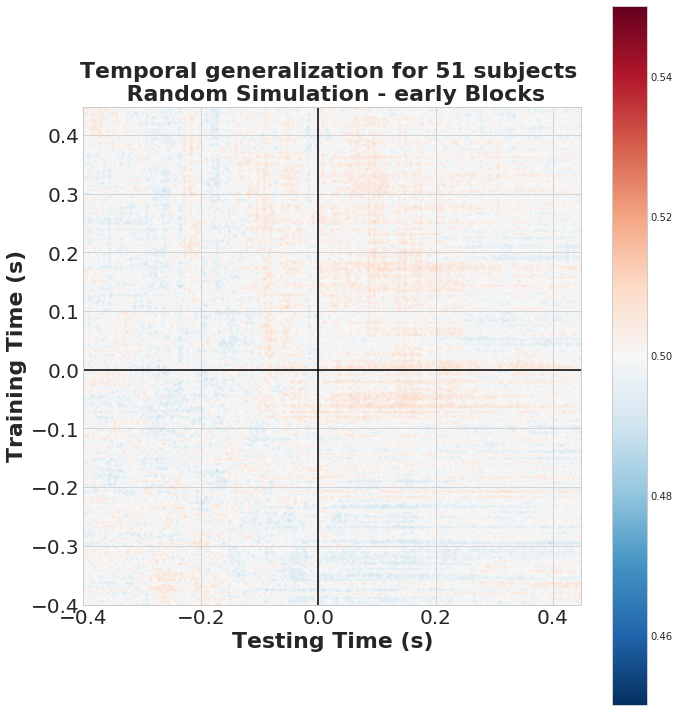

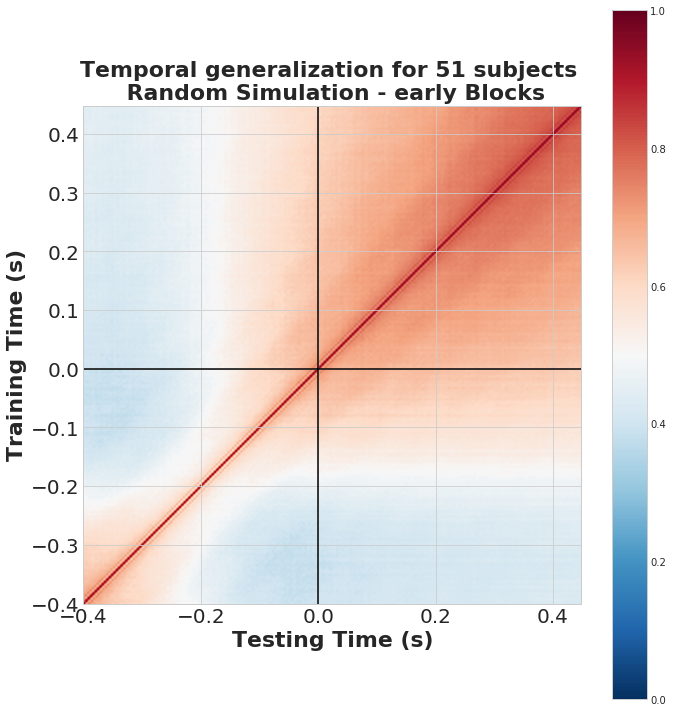

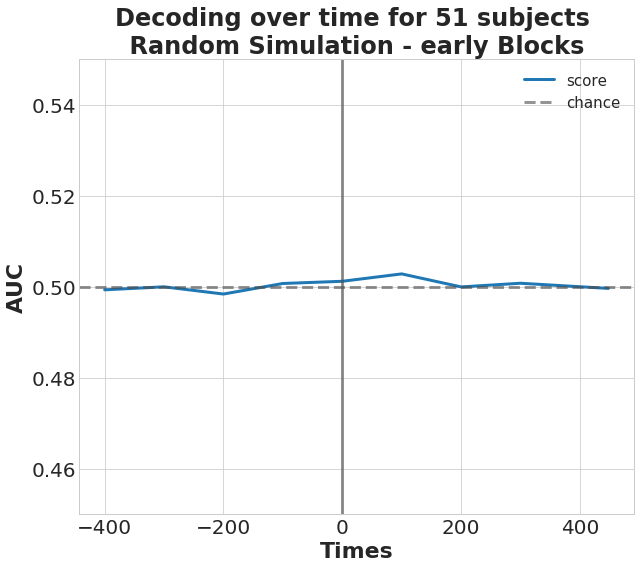

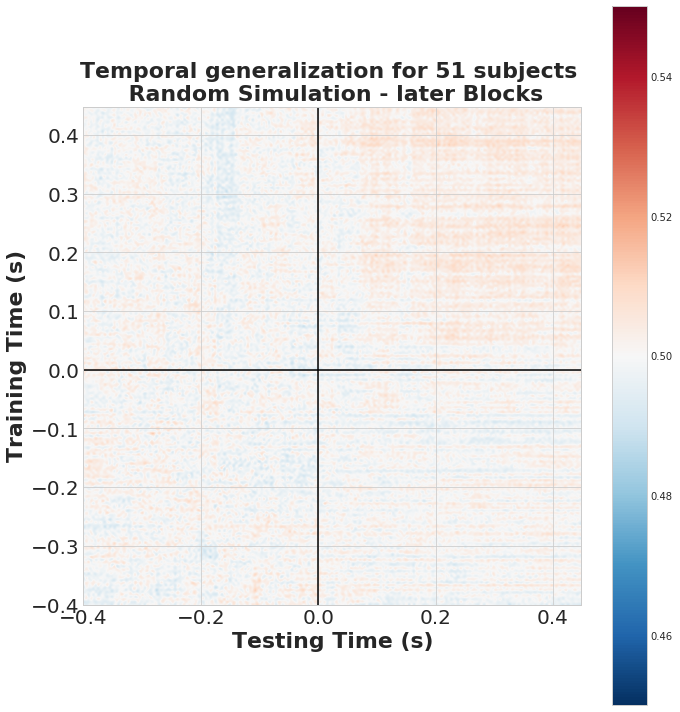

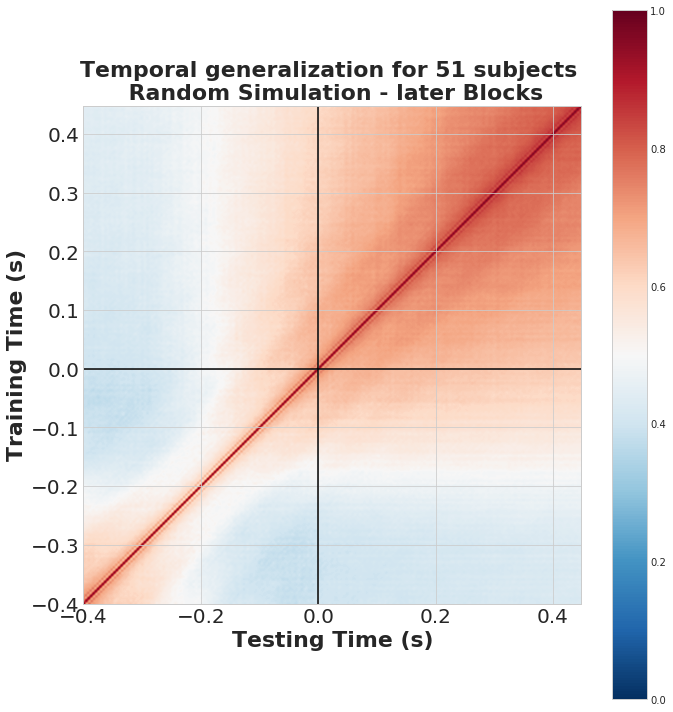

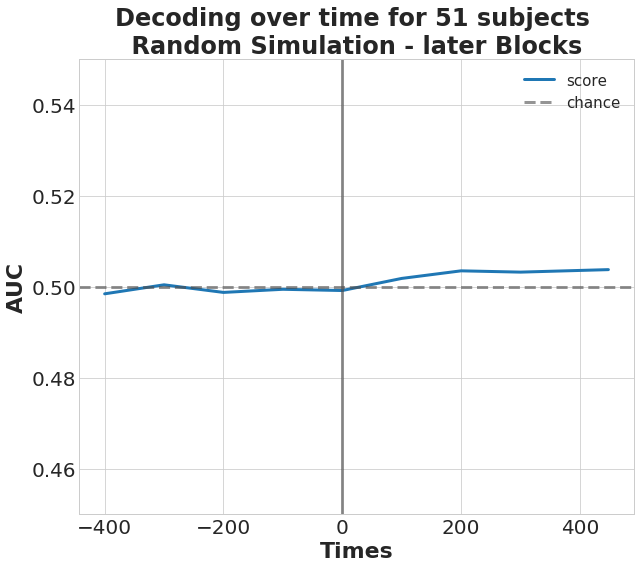

In [13]:
selected_subj_P1 = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15, 16, \
                    42, 43, 44, 45, 47, 48, 51, 53, \
                    55, 56, 57, 58, 59, 60, 61, 62, 64, \
                    66, 67, 68, 71, 72, 73]
selected_subj_P2 = [18, 19, 20, 21, 23, 24, 26, 28, 29, \
                   31, 33, 34, 35, 36, 38, 39]

subj_p1 = selected_subj_P1.copy()
subj_p2 = selected_subj_P2.copy()
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
# early ------------- #
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#

args = arguments('early', 'removeevoked', 'False', 'Trgt_Loc_prev', 'False' )
args.SAVE_RESULT_ROOT = '../../../results/temp_gen/eCortex/rand_simulations/'
#
scores_pck_p_e = combine_subj_rand_scores(args, subj_p1, subj_p2)
[p, pd, p_fit, pd_fit] = scores_pck_p_e

num_tot_subjects = scores_pck_p_e[0].shape[0]

avgP_e          = np.mean(p, axis=1) #avg over iterations -> should use this for the stat analysis
avgPdiag_e      = np.mean(pd, axis=1)
avgPS_e         = np.mean(avgP_e, axis=0) #avg over subjects
avgPSdiag_e     = np.mean(avgPdiag_e, axis=0)

avgP_e_fit      = np.mean(p_fit, axis=1)
avgPdiag_e_fit  = np.mean(pd_fit, axis=1)
avgPS_e_fit     = np.mean(avgP_e_fit, axis=0)
avgPSdiag_e_fit = np.mean(avgPdiag_e_fit, axis=0)

#------------------------------------------------------------------------------#
is_diff = False
title = 'Random Simulation - %s Blocks' %(args.cond_block)
#-------------------------------------------------------------------------------------
score_diag = avgPdiag_e.copy()
scores     = np.mean(avgP_e.copy(), axis=0) # avg over subjects, TimeXTime
scores_fit = np.mean(avgP_e_fit.copy(), axis=0) # avg over subjects, TimeXTime
binned_avg_score_diag, plot_times, clust_pck = stat_anal(score_diag, title, is_diff)


#-------------------------------------------------------------------------------------
fig_str = 'fig_rand_temp_gen_matrix_%sBlocks_%s' %(args.cond_block, args.mtdt_feat)
vmin=0.45; vmax=0.55
plot_scores(args, title, scores, fig_str,vmin, vmax)

fig_str = 'fig_rand_temp_gen_matrix_fit_%sBlocks_%s' %(args.cond_block, args.mtdt_feat)
vmin=0.; vmax=1
plot_scores(args, title, scores_fit, fig_str,vmin, vmax)

fig_str = 'fig_rand_temp_gen_scores_%sBlocks_%s' %(args.cond_block, args.mtdt_feat)
plot_scores_stat(args, title, binned_avg_score_diag, plot_times,\
                 clust_pck, str(num_tot_subjects), is_diff, fig_str)

#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
# later ------------- #
#------------------------------------------------------------------------------#
#------------------------------------------------------------------------------#
args = arguments('later', 'removeevoked', 'False', 'Trgt_Loc_prev', 'False' )
args.SAVE_RESULT_ROOT = '../../../results/temp_gen/eCortex/rand_simulations/'
#
scores_pck_p_l = combine_subj_rand_scores(args, subj_p1, subj_p2)
[p, pd, p_fit, pd_fit] = scores_pck_p_l

avgP_l          = np.mean(p, axis=1) #avg over iterations -> should use this for the stat analysis
avgPdiag_l      = np.mean(pd, axis=1)
avgPS_l         = np.mean(avgP_l, axis=0)
avgPSdiag_l     = np.mean(avgPdiag_l, axis=0)

avgP_l_fit      = np.mean(p_fit, axis=1)
avgPdiag_l_fit  = np.mean(pd_fit, axis=1)
avgPS_l_fit     = np.mean(avgP_l_fit, axis=0)
avgPSdiag_l_fit = np.mean(avgPdiag_l_fit, axis=0)

#------------------------------------------------------------------------------#
title = 'Random Simulation - %s Blocks' %(args.cond_block)
#-------------------------------------------------------------------------------------
score_diag = avgPdiag_l.copy()
scores     = np.mean(avgP_l.copy(), axis=0) # avg over subjects, TimeXTime
scores_fit = np.mean(avgP_l_fit.copy(), axis=0) # avg over subjects, TimeXTime
binned_avg_score_diag, plot_times, clust_pck = stat_anal(score_diag, title, is_diff)


#-------------------------------------------------------------------------------------
fig_str = 'fig_rand_temp_gen_matrix_%sBlocks_%s' %(args.cond_block, args.mtdt_feat)
vmin=0.45; vmax=0.55
plot_scores(args, title, scores, fig_str,vmin, vmax)

fig_str = 'fig_rand_temp_gen_matrix_fit_%sBlocks_%s' %(args.cond_block, args.mtdt_feat)
vmin=0; vmax=1
plot_scores(args, title, scores_fit, fig_str,vmin, vmax)

fig_str = 'fig_rand_temp_gen_scores_%sBlocks_%s' %(args.cond_block, args.mtdt_feat)
plot_scores_stat(args, title, binned_avg_score_diag, plot_times,\
                 clust_pck, str(num_tot_subjects), is_diff, fig_str)



plot times [-400. -300. -200. -100.    0.  100.  200.  300.  448.]
Using a threshold of 2.008559
stat_fun(H1): min=-0.861295 max=1.336360
Running initial clustering
Found 0 clusters
score_subtract (51, 213)
binned_score_subtract (51, 9, 1)


../../../results/temp_gen/eCortex/rand_simulations/figs/fig_rand_temp_gen_matrix_diffBlocks_Trgt_Loc_prev.tiff


<ipython-input-9-ba0d49576fd9>:18: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, clusters_pv, H0 = mne.stats.spatio_temporal_cluster_1samp_test(binned_score_subtract, tail=0)


../../../results/temp_gen/eCortex/rand_simulations/figs/fig_rand_temp_gen_matrix_fit_diffBlocks_Trgt_Loc_prev.tiff
(9,)
insude plot times shape (9,)
insude plot diag_scores shape (9,)


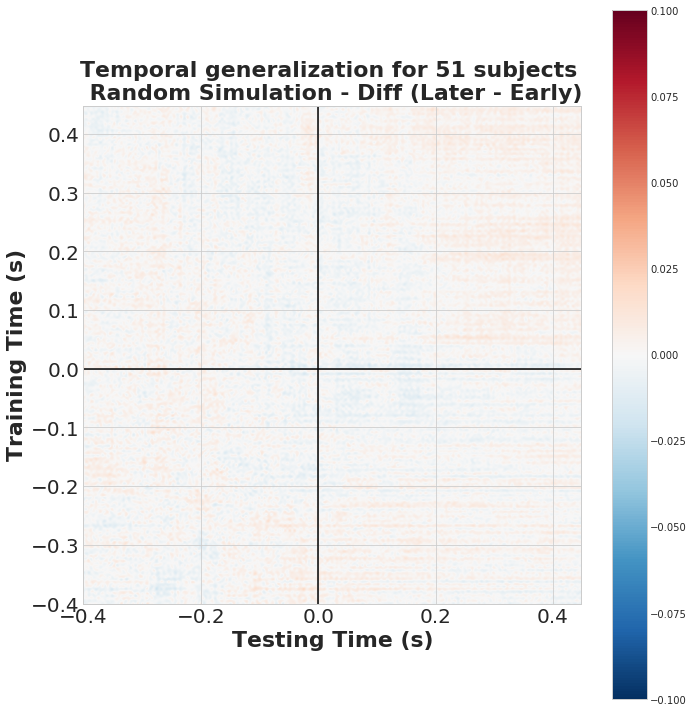

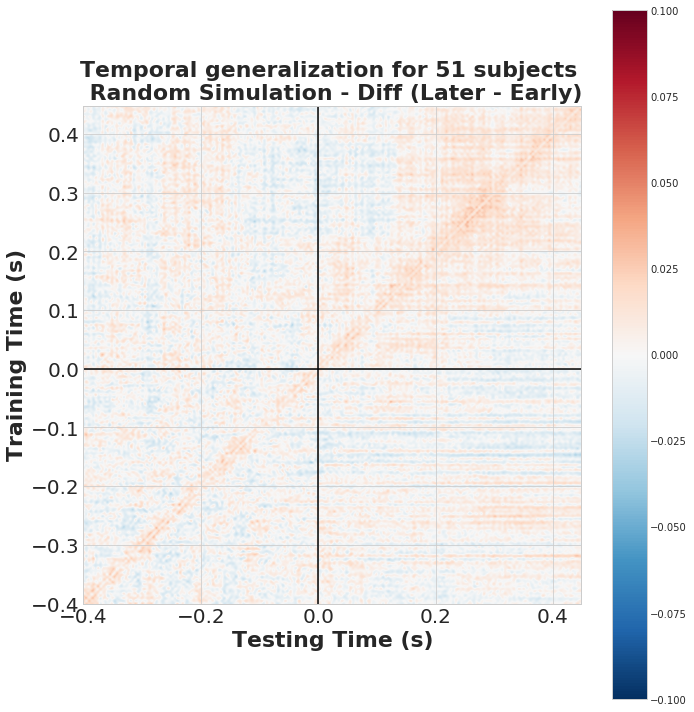

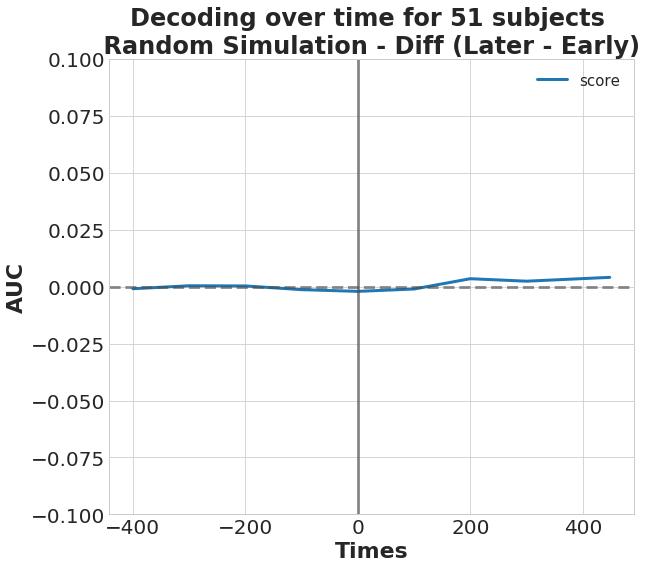

In [14]:
#------------------------------------------------------------------------------#
# Diff ------------- #
avgP_d     = avgP_l.copy() - avgP_e.copy()
avgPdiag_d = avgPdiag_l.copy() - avgPdiag_e.copy()
avgP_d_fit = avgP_l_fit.copy() - avgP_e_fit.copy()
avgPdiag_d_fit = avgPdiag_l_fit.copy() - avgPdiag_e_fit.copy()

#------------------------------------------------------------------------------#


#------------------------------------------------------------------------------#
is_diff = True
title = 'Random Simulation - Diff (Later - Early)'
#-------------------------------------------------------------------------------------
score_diag = avgPdiag_d.copy()
scores     = np.mean(avgP_d.copy(), axis=0) # avg over subjects, TimeXTime
scores_fit = np.mean(avgP_d_fit.copy(), axis=0) # avg over subjects, TimeXTime
binned_avg_score_diag, plot_times, clust_pck = stat_anal(score_diag, title, is_diff)


#-------------------------------------------------------------------------------------
fig_str = 'fig_rand_temp_gen_matrix_%sBlocks_%s' %('diff', args.mtdt_feat)
vmin=-0.1; vmax=0.1
plot_scores(args, title, scores, fig_str,vmin, vmax)

fig_str = 'fig_rand_temp_gen_matrix_fit_%sBlocks_%s' %('diff', args.mtdt_feat)
vmin=-0.1; vmax=0.1
plot_scores(args, title, scores_fit, fig_str,vmin, vmax)

fig_str = 'fig_rand_temp_gen_scores_%sBlocks_%s' %('diff', args.mtdt_feat)
plot_scores_stat(args, title, binned_avg_score_diag, plot_times,\
                 clust_pck, str(num_tot_subjects), is_diff, fig_str)

